<a href="https://colab.research.google.com/github/Bruno-BRG/testeBCI/blob/main/TesteNovaArquitetura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ─── GPU CHECK ────────────────────────────────────────────────────────────────
!nvidia-smi

# ─── TENSORFLOW SETUP ─────────────────────────────────────────────────────────
import tensorflow as tf

# List GPUs
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("❌ No GPU detected by TensorFlow. Make sure your runtime is set to GPU.")
else:
    # Enable memory growth to avoid full-GPU allocation
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(f"✅ TensorFlow sees {len(gpus)} physical GPU(s) and {len(logical_gpus)} logical GPU(s).")

# ─── PYTORCH SETUP ────────────────────────────────────────────────────────────
import torch

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🗄️  PyTorch will use: {device}")

# ─── USAGE EXAMPLE ────────────────────────────────────────────────────────────
# When you build your model and load data, remember:
# model = MyModel(...).to(device)
# data = data.to(device)
# target = target.to(device)
# ... then forward/backward as usual.


Tue May 20 22:22:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 76.4 MB/s eta 0:00:00


# Modelo EEGNet


Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 398, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 398, 32)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 398, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 1, 398, 128)    │         2,048 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 398, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 1, 398, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 1, 99, 128)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 99, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 1, 99, 128)     │        18,432 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 99, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1, 99, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 1, 12, 128)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 8, 15, 128)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 12, 128)     │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1, 12, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 1, 3, 128)      │        17,408 │
│ (SeparableConv2D)               │                        │             

 Total params: 583,170 (2.22 MB)

 Trainable params: 582,082 (2.22 MB)

 Non-trainable params: 1,088 (4.25 KB)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 176ms/step - accuracy: 0.5961 - loss: 0.9664 - val_accuracy: 0.6715 - val_loss: 0.6915
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5945 - loss: 0.7676 - val_accuracy: 0.3285 - val_loss: 0.6959
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6381 - loss: 0.6941 - val_accuracy: 0.3285 - val_loss: 0.7162
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6421 - loss: 0.6628 - val_accuracy: 0.3293 - val_loss: 0.7046
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6544 - loss: 0.6532 - val_accuracy: 0.3775 - val_loss: 0.7030
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6560 - loss: 0.6366 - val_accuracy: 0.6346 - val_loss: 0.6693
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6765 - loss: 0.6299 - val_accuracy: 0.5641 - val_loss: 0.6663
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6684 - loss: 0.6226 - val_accuracy:

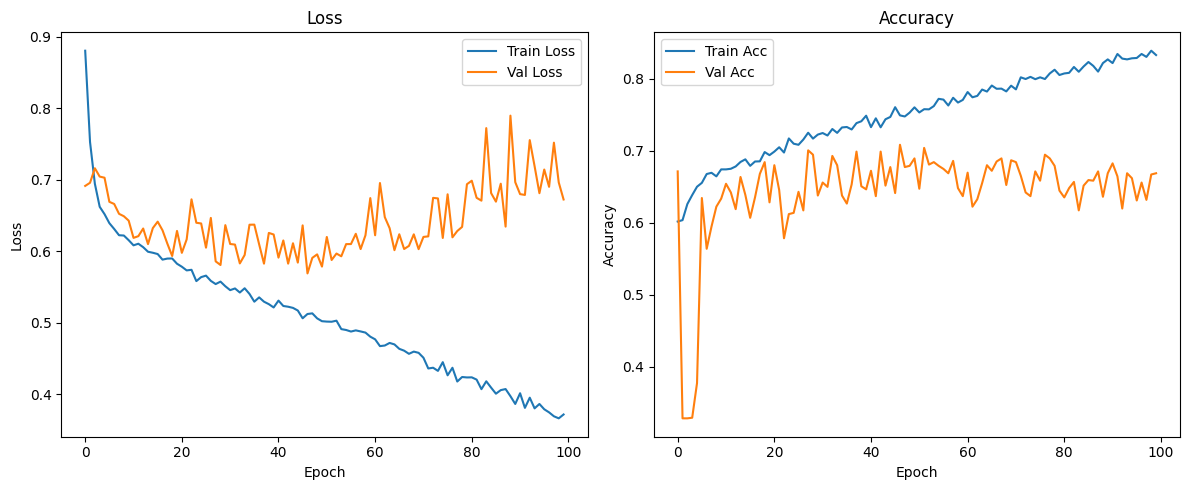

In [12]:
import numpy as np
import mne
from mne import concatenate_raws
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    DepthwiseConv2D,
    SeparableConv2D,
    BatchNormalization,
    Activation,
    AveragePooling2D,
    Dropout,
    Flatten,
    Dense,
    ZeroPadding2D,
    MaxPool2D
)
from collections import Counter
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Parameters
IMAGINE_LEFT_RIGHT = [4, 8, 12]
subjects = range(1, 110)
selected_channels = [
    'C3..', 'C4..', 'Fp1.', 'Fp2.', 'F7..', 'F3..', 'F4..', 'F8..',
    'T7..', 'T8..', 'P7..', 'P3..', 'P4..', 'P8..', 'O1..', 'O2..'
]

# Load raw data paths
physionet_paths = np.concatenate([
    eegbci.load_data(subj, IMAGINE_LEFT_RIGHT, path="/content/drive/MyDrive/Colab Notebooks/mne_data")
    for subj in subjects
])

# Read raw EDF objects
raws = [
    mne.io.read_raw_edf(p, preload=True, stim_channel='auto', verbose='WARNING')
    for p in physionet_paths
]

# Resample all to lowest sampling frequency
sfreqs = np.unique([r.info['sfreq'] for r in raws])
target_sfreq = int(sfreqs.min())
for r in raws:
    r.resample(target_sfreq, npad='auto')
raw = concatenate_raws(raws)

# Band-pass filter and pick channels
raw.filter(8., 30., fir_design='firwin', verbose=False)
raw.pick_channels(selected_channels)

# Create epochs for left (T1) vs right (T2)
events, _ = mne.events_from_annotations(raw)
event_id = dict(T1=1, T2=2)
eeg_picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
epochs = mne.Epochs(
    raw, events, event_id=event_id, tmin=1, tmax=4.1,
    proj=False, picks=eeg_picks, baseline=None,
    preload=True, verbose=False
)

# Extract data and labels
X = (epochs.get_data() * 1e6).astype(np.float32)
y = epochs.events[:, -1] - 1

# Normalize each trial per channel
X_reshaped = X.reshape(X.shape[0], X.shape[1], -1)
for i in range(X_reshaped.shape[0]):
    X_reshaped[i] = StandardScaler().fit_transform(X_reshaped[i].T).T
X = X_reshaped.reshape(X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Add channel dimension
X_train = X_train.transpose(0, 1, 2)[..., np.newaxis]
X_test = X_test.transpose(0, 1, 2)[..., np.newaxis]

# Enhanced EEGNet with scaled-up filters and additional blocks
def EEGNet(nb_classes, Chans, Samples,
           dropoutRate=0.5,
           kernLength=64,
           F1=32,
           D=4,
           F2=128,
           F3=128
           ):
    input_main = Input(shape=(Chans, Samples, 1))

    # Block 1: temporal + depthwise spatial conv
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input_main)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)

    # Block 2: separable conv
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropoutRate)(x)

    # Block 3: extra conv + pooling (height pooling removed)
    x = ZeroPadding2D(padding=((4, 3), (2, 1)))(x)
    x = Conv2D(F3, (8, 4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPool2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)

    # Block 4: additional separable conv + reduced pooling
    x = SeparableConv2D(F3, (1, 8), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPool2D((1, 2))(x)
    x = Dropout(dropoutRate)(x)

    # Classification head
    x = Flatten()(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(dropoutRate)(x)
    output = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs=input_main, outputs=output)

# Instantiate and compile
model = EEGNet(nb_classes=2,
               Chans=X_train.shape[1],
               Samples=X_train.shape[2])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

# Evaluate performance
y_pred = model.predict(X_test).argmax(axis=-1)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}, "
      f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Modelo usando spectograma

In [ ]:
import os
import numpy as np
import mne
from mne import concatenate_raws
from mne.datasets import eegbci
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Diretório de espectrogramas (sem logging)
spectrogram_dir = r"C:\Users\Chari\OneDrive\Documentos\GitHub\teste01\spectrograms"
os.makedirs(spectrogram_dir, exist_ok=True)

# Parâmetros gerais
IMAGINE_LEFT_RIGHT = [4, 8, 12]
subjects = range(1, 21)
selected_channels = ['C3..', 'C4..', 'Fp1.', 'Fp2.', 'F7..', 'F3..', 'F4..', 'F8..',
                     'T7..', 'T8..', 'P7..', 'P3..', 'P4..', 'P8..', 'O1..', 'O2..']

# Carregamento dos dados
physionet_paths = np.concatenate([
    eegbci.load_data(subj, IMAGINE_LEFT_RIGHT, path=r"C:\Users\Chari\OneDrive\Documentos\GitHub\teste01\mne_data") for subj in subjects
])
raws = [mne.io.read_raw_edf(p, preload=True, stim_channel='auto', verbose='WARNING') for p in physionet_paths]
raw = concatenate_raws(raws)
raw.filter(8., 30., fir_design='firwin', verbose=False)
raw.pick_channels(selected_channels)

# Eventos e epochs
events, _ = mne.events_from_annotations(raw)
event_id = dict(T1=1, T2=2)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=1, tmax=4.1, baseline=None, preload=True, verbose=False)

# Função de geração de espectrograma
def generate_spectrogram(trial, fs=250, window='hann', nperseg=64, noverlap=50):
    f, t, Zxx = stft(trial, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    mu_band = (f >= 8) & (f <= 14)
    beta_band = (f >= 16) & (f <= 30)
    spec_mu = np.abs(Zxx[mu_band, :])
    spec_beta = np.abs(Zxx[beta_band, :])
    spec_mu = np.resize(spec_mu, (20, 32))
    spec_beta = np.resize(spec_beta, (20, 32))
    return np.concatenate((spec_mu, spec_beta), axis=0)

# Geração de espectrogramas e labels
X, y = [], []
for i, (epoch, label) in enumerate(zip(epochs.get_data(), epochs.events[:, -1] - 1)):
    combined_spec = []
    for ch_idx, ch_data in enumerate(epoch):
        spec = generate_spectrogram(ch_data)
        combined_spec.append(spec)
    full_image = np.stack(combined_spec, axis=-1)  # shape (40, 32, 16)
    X.append(full_image)
    y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# CNN ajustada para 16 canais

def build_model(input_shape=(40, 32, 16), num_classes=2):
    inp = Input(shape=input_shape)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    x3 = Concatenate()([x1, x2])
    x4 = MaxPooling2D((2, 2))(x3)
    x5 = Conv2D(64, (3, 3), activation='relu', padding='same')(x4)
    x6 = Flatten()(x5)
    x6 = Dropout(0.5)(x6)
    out = Dense(num_classes, activation='softmax')(x6)
    return Model(inputs=inp, outputs=out)

# Treinamento do modelo
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Avaliação
y_pred = model.predict(X_test).argmax(axis=-1)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}, F1 Score: {f1_score(y_test, y_pred):.4f}")

In [ ]:
import os
import numpy as np
import mne
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Diretório dos arquivos GDF do BCI IV 2b
data_path = 'BCICIV_2b_gdf'
subjects = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09']
sessions = ['01T']  # Apenas sessões de treino

raw_list = []
for subj in subjects:
    for sess in sessions:
        file_path = os.path.join(data_path, f'{subj}{sess}.gdf')
        print(f"Verificando: {file_path}")
        if os.path.exists(file_path):
            try:
                raw = mne.io.read_raw_gdf(file_path, preload=True, stim_channel=None, verbose='ERROR')
                raw.pick_channels(['C3', 'Cz', 'C4'])
                raw.filter(8., 30., fir_design='firwin', verbose=False)
                raw_list.append(raw)
            except Exception as e:
                print(f"Erro ao ler {file_path} com MNE: {e}")
        else:
            print(f"Arquivo não encontrado: {file_path}")

if not raw_list:
    raise RuntimeError("Nenhum arquivo GDF foi carregado com MNE. Verifique os dados.")

raw = mne.concatenate_raws(raw_list)
events, _ = mne.events_from_annotations(raw)
event_id = {'Left Hand': 1, 'Right Hand': 2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=3.0, tmax=7.0,
                    baseline=None, preload=True, verbose=False)

fs = int(raw.info['sfreq'])
X, y = [], []
for epoch, label in zip(epochs.get_data(), epochs.events[:, -1]):
    spec = []
    for ch_data in epoch:
        f, t, Zxx = stft(ch_data, fs=fs, nperseg=64, noverlap=32)
        mu_band = (f >= 8) & (f <= 14)
        beta_band = (f >= 16) & (f <= 30)
        spec_mu = np.abs(Zxx[mu_band, :])
        spec_beta = np.abs(Zxx[beta_band, :])
        spec_mu = np.resize(spec_mu, (20, 32))
        spec_beta = np.resize(spec_beta, (20, 32))
        spec_combined = np.concatenate((spec_mu, spec_beta), axis=0)
        spec.append(spec_combined)
    X.append(np.stack(spec, axis=-1))
    y.append(label - 1)

X = np.array(X, dtype=np.float32)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_model(input_shape=(40, 32, 3), num_classes=2):
    inp = Input(shape=input_shape)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    x3 = Concatenate()([x1, x2])
    x4 = MaxPooling2D((2, 2))(x3)
    x5 = Conv2D(64, (3, 3), activation='relu', padding='same')(x4)
    x6 = Flatten()(x5)
    x6 = Dropout(0.5)(x6)
    out = Dense(num_classes, activation='softmax')(x6)
    return Model(inputs=inp, outputs=out)

model = build_model(input_shape=X_train.shape[1:], num_classes=2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)
y_pred = model.predict(X_test).argmax(axis=-1)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}, F1 Score: {f1_score(y_test, y_pred):.4f}")